In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
import warnings
from prince import FAMD
from bayes_opt import BayesianOptimization
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
import numpy as np
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('master_data.csv', index_col=0)
df.index = pd.to_datetime(df.index)
df = df.loc['1989-08-23':] #df = df.loc['1989-07-7':]
df['mom'] = -df['mom_d'] + df['mom_u']
df = df.drop(columns=['mom_u', 'mom_d'])
df['label_day'] = ~df['decision'].isna()
df = df.fillna(method='ffill')
df = df.iloc[1:]
df.to_csv('master_data_clean.csv')

### To do...
fix the decision column

In [3]:
# define the columns
monthly = ['pce','ue','cars','house','cli','exports','rgdp','gdpd','veloc', 'ffr','mich']
labels = ['decision', 'ffr', 'change']
daily = ['spx','usd', 'loan']
categorical = ['fed_party','potus_party','recess', 'mom']

In [4]:
# union of all columns
all_cols = monthly + daily + categorical + labels
shared = set(df.columns.intersection(all_cols).to_list())
df_cols = df.columns.to_list()

# find the unique values of all_cols
unique_ourlabels = {col if col not in shared else None for col in all_cols}
unique_dflabels = {col if col not in shared else None for col in df_cols}
unique_ourlabels.remove(None)
unique_dflabels.remove(None)
display(unique_ourlabels)
display(unique_dflabels)



set()

{'label_day'}

In [5]:
# forward fill all nan values
def collapse(df, key = 'label_day', start = 7, end = 60, cat_col = [], daily_col = [], other = [], labels = []):
    # Get our different dataframes
    categorical = df[cat_col]
    daily = df[daily_col]
    monthly = df[other]
    keep = df[key]
    labels = df[labels]

    # create the windows
    event_days = df[df[key]].index

    ################## Handle Categorical and Label Data ##################
    cat_collapsed = categorical[keep]
    y_labels = labels[keep]

    ################## Handle Monthly Data ##################
    # Create event windows
    windows = []
    for day in event_days:
        # Calculate start and end days of the window
        start_day = day - pd.Timedelta(days=start)
        end_day = day - pd.Timedelta(days=end)

        # Ensure start_day is not before the start of the dataset
        if end_day < df.index[0]:
            end_day = df.index[0]

        windows.append((start_day, end_day))

    # Initialize a list to store aggregated data
    aggregated_data = []

    for (start_day, end_day) in windows:
        # Select data within the window
        window_data = monthly.loc[end_day:start_day]

        # Apply your custom aggregation function
        final_vals = window_data.loc[start_day]
        change = final_vals - window_data.iloc[0]
        # relabel the change columns to include a d_ prefix
        change = change.rename(lambda x: 'd_' + x)

        # concatenate the data horizontally
        aggregated_window = pd.concat([final_vals, change], axis=0)
        aggregated_data.append(aggregated_window)

    # Combine aggregated data
    aggregated_monthly = pd.concat(aggregated_data, axis=1).T
    aggregated_monthly.index = event_days

    ################## Handle Daily Data ##################
    # define the model
    model = linear_model.LinearRegression()
    daily_agg = []

    # Get the names of the features
    daily_feat = daily.columns
    b0_name = ['b0_' + feat for feat in daily_feat]
    b1_name = ['b1_' + feat for feat in daily_feat]

    for (start_day, end_day) in windows:
        # Select data within the window
        window_data = daily.loc[end_day:start_day]
        time = np.arange(len(window_data)).reshape(-1, 1)

        # Initialize lists to store betas for each feature
        beta0 = []
        beta1 = []

        # Loop through each feature and fit the model
        for feat in daily_feat:
            model.fit(time, window_data[feat])
            beta0.append(model.intercept_)
            beta1.append(model.coef_[0])

        # Create DataFrames for betas
        beta0_df = pd.DataFrame([beta0], columns=b0_name)
        beta1_df = pd.DataFrame([beta1], columns=b1_name)

        # concatenate the data horizontally
        aggregated_window = pd.concat([beta0_df, beta1_df], axis=1)
        daily_agg.append(aggregated_window)

    # Combine aggregated data
    aggregated_daily = pd.concat(daily_agg, axis=0)
    aggregated_daily.index = event_days

    ################## Combine Data ##################
    # Combine all data
    combined = pd.concat([cat_collapsed, aggregated_monthly, aggregated_daily], axis=1)
    return combined, y_labels

In [6]:
date_ranges = [(7,60),(2,60),(7,120),(2,120),(7,42),(2,42)]

In [7]:
# loop through the date ranges and save the data
for dates in date_ranges:
    beta_data, label_data = collapse(df, start = dates[0], end = dates[1], cat_col = categorical, daily_col = daily, other = monthly, labels = labels)
    beta_data.to_csv('beta_dates/beta_data_' + str(dates[0]) + '_' + str(dates[1]) + '.csv')
label_data.to_csv('beta_dates/true_labels.csv')

In [8]:
# make a pipe of a random forest on beta_data_2_42.csv
from sklearn.ensemble import RandomForestClassifier

# load the data
beta_data = pd.read_csv('beta_dates/beta_data_2_42.csv', index_col=0)
beta_data.index = pd.to_datetime(beta_data.index)
labels = pd.read_csv('beta_dates/true_labels.csv', index_col=0)['decision']

N=300
for i in range(N):

    # print the best parameters
    model = RandomForestClassifier(max_depth=3, max_features='auto', min_samples_leaf=2, min_samples_split=5, n_estimators=100)
    model.fit(beta_data, labels)
    importances = model.feature_importances_

    # Print feature importances
    importance = {feature: importance for feature, importance in zip(beta_data.columns, importances)}
    importance = pd.DataFrame(importance, index=[0])
    importance = importance.T
    importance.columns = ['importance_' + str(i)]

    if i == 0:
        importance_df = importance
    else:
        importance_df = pd.concat([importance_df, importance], axis=1)

importance_df['mean'] = importance_df.mean(axis=1)
importance_df['std'] = importance_df.std(axis=1)
importance_df = importance_df.sort_values(by='mean', ascending=False)
importance_avg = importance_df[['mean', 'std']]

In [14]:


# do an xgboost regression on the data
def encoder(df, col_split):
    """
    Prepares the data for the model by standardizing the continuous features, 
    converting the categorical features to strings, 
    and converting sparse columns to a dense format for FAMD.
    """
    categorical_cols = df.columns[:col_split]

    # converting the categorical features to strings
    df[categorical_cols] = df[categorical_cols].astype('category')

    return df


def load_data_cv(data_address='beta_dates/beta_data_7_60.csv', label_address='beta_dates/true_labels.csv', label_name = 'ffr'):
    df = pd.read_csv(data_address, index_col=0)
    y = pd.read_csv(label_address, index_col=0)[label_name].values
    X = encoder(df, 4)
    return X, y

X, y = load_data_cv('beta_dates/beta_data_2_42.csv')
components = 12

# Perform FAMD with 2 components
famd = FAMD(n_components=components, n_iter=10, copy=True, check_input=True, engine='sklearn', random_state=42)
famd.fit(X)
X_famd = famd.transform(X)

# Number of splits for K-Fold Cross-Validation
n_splits = 7
kf = KFold(n_splits=n_splits, shuffle=True)

# Create a pipeline with the XGBRegressor
pipe = Pipeline([
    ('xgb', XGBRegressor(objective='reg:squarederror',enable_categorical=True)),  # Updated for regression
])

def xgb_evaluate(gamma, learning_rate, max_depth, n_estimators, reg_alpha, reg_lambda, subsample, colsample_bytree, min_child_weight):
    params = {
        'xgb__gamma': gamma,
        'xgb__learning_rate': learning_rate,
        'xgb__max_depth': int(max_depth),
        'xgb__n_estimators': int(n_estimators),
        'xgb__reg_alpha': reg_alpha,
        'xgb__reg_lambda': reg_lambda,
        'xgb__subsample': subsample,
        'xgb__colsample_bytree': colsample_bytree,
        'xgb__min_child_weight': min_child_weight,
    }
    pipe.set_params(**params)
    pipe.fit(X_train, y_train)
    predictions = pipe.predict(X_test)
    return -mean_squared_error(y_test, predictions)  # Negative MSE for optimization

# Perform K-Fold Cross-Validation
mse_scores = []
params = []

for train_index, test_index in kf.split(X_famd, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    optimizer = BayesianOptimization(
        f=xgb_evaluate,
        pbounds={
            'gamma': (.1, 10),
            'learning_rate': (0.01, 1),
            'max_depth': (3, 6),
            'n_estimators': (80, 200),
            'reg_alpha': (.5, 10),
            'reg_lambda': (.5, 10),
            'subsample': (0.1, 1.0),
            'colsample_bytree': (0.1, 1.0),
            'min_child_weight': (3, 10),
        },
    )

    optimizer.maximize(init_points=5, n_iter=200)

    # Retrieve and adjust best parameters for pipeline
    xgb_best_params = optimizer.max['params']
    xgb_best_params_for_pipeline = {'xgb__' + key: int(value) if key in ['max_depth', 'n_estimators'] else value for key, value in xgb_best_params.items()}

    pipe.set_params(**xgb_best_params_for_pipeline)
    pipe.fit(X_train, y_train)

    predictions = pipe.predict(X_test)

    mse_scores.append(-optimizer.max['target'])  # MSE should be positive

    print("Best Parameters for Pipeline:", xgb_best_params_for_pipeline)
    print("Best Performance (MSE):", -optimizer.max['target'])

print("Average MSE:", np.mean(mse_scores))


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
| 1         | -0.1468   | 0.972     | 2.523     | 0.1175    | 4.894     | 8.267     | 111.7     | 2.839     | 6.788     | 0.9695    |
| 2         | -0.3874   | 0.7909    | 6.249     | 0.813     | 5.718     | 5.163     | 171.0     | 1.747     | 9.755     | 0.9354    |
| 3         | -0.2379   | 0.7118    | 5.628     | 0.6401    | 3.155     | 6.71      | 127.8     | 7.95      | 7.511     | 0.5258    |
| 4         | -0.4021   | 0.9236    | 9.05      | 0.5544    | 3.384     | 5.199     | 167.7     | 7.021     | 6.87      | 0.1767    |
| 5         | -0.4806   | 0.2021    | 9.199     | 0.5736    | 3.782     | 4.211     | 112.6     | 3.225     | 6.524     | 0.2287    |
| 6         | -0.5185   | 0.6696    | 6.185     | 0.2103    | 

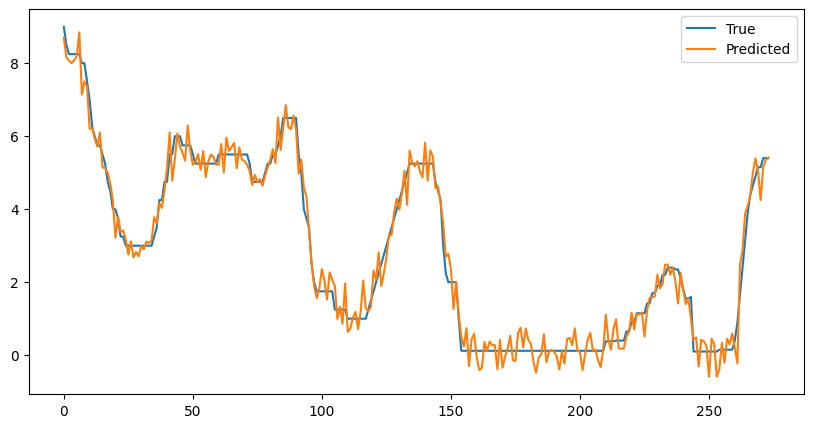

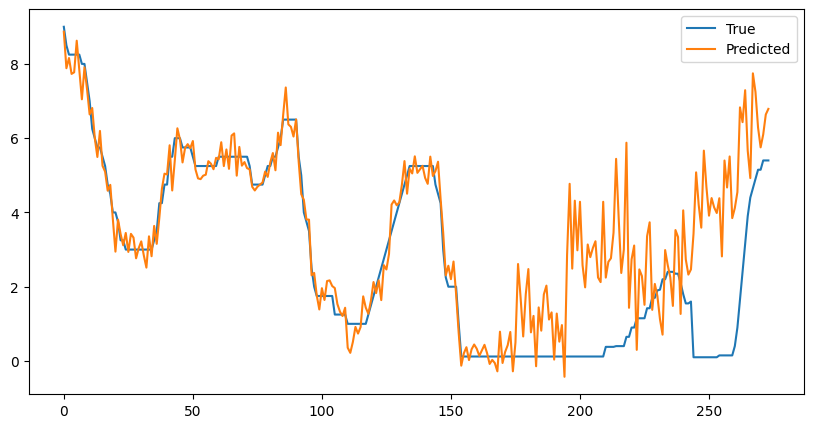

In [51]:
# get the best parameters
best_params = optimizer.max['params']
best_params['max_depth'] = int(best_params['max_depth'])
best_params['n_estimators'] = int(best_params['n_estimators'])

# fit the model
model_whole = XGBRegressor(objective='reg:squarederror',enable_categorical=True, **best_params)
model_whole.fit(X_famd, y)
predictions_whole = model_whole.predict(X_famd)

# plot the predictions vs the true values
plt.figure(figsize=(10,5))
plt.plot(y, label='True')
plt.plot(predictions_whole, label='Predicted')
plt.legend()
plt.show()


X_train = X_famd[:175]
y_train = y[:175]

model_first = XGBRegressor(objective='reg:squarederror',enable_categorical=True, **best_params)
model_first.fit(X_train, y_train)
predictions_first = model_first.predict(X_famd)
plt.figure(figsize=(10,5))
plt.plot(y, label='True')
plt.plot(predictions_first, label='Predicted')
plt.legend()
plt.show()

# make a dataframe of the predictions
predictions_df = pd.DataFrame(np.array([predictions_first, predictions_whole, y]).T, index=X.index)
predictions_df.columns = ['diverge_at_index_175', 'overfit', 'actual']
predictions_df.to_csv('predictions.csv')

In validating our models, we ran k-fold cross-validation across time, randomly assigning different FOMC decisions from any time period with a mix of past and future decisions. Interpreting our model with such training methods implies that future conditions surrounding FOMC decisions are being used to predict current decisions. This makes little practical sense as it may violate causality, raising significant issues with the validity of this initial model. In practice, this model will use past data to predict future FOMC decisions, a significant deviation from the training of our current model.

To combat this potential misuse of our model, we employ a new implementation of a new sequential jackknife strategy. We start by training our model on the first 137 FOMC decisions (the first half of our data), and train on all previous decisions to predict only the very next decision. After obtaining this prediction, we wait for the next period and repeat by training on all available data (including the previous decision that is now available in our dataset) and predict the following decision once more. Continuing this pattern, we calculate predictions for every sequential decision akin to how this model would be practically applied, as described in the motivation section.

While holding all other aspects and assumptions of our model constant, as previously discussed, we replace k-fold cross-validation with this "sequential jackknife" approach, matching the interpretability of our data to get the following results: